# Unmasking Basketball
## Part 1: Page Scraping Using Python and Beautiful Soup

In this series, powerful Python libraries are leveraged to help uncover some hidden statistical truths in basketball. The first step in any data driven approach is to identify and collect the data needed.

Luckily for us, [Basketball-Reference.com](https://www.basketball-reference.com/) hosts pages of basketball data that can be easily scraped. The processes of this walkthrough can be easily applied to any number of their pages, but for this case, we plan on scraping seasonal statistics of multiple rookie classes.

## The Objectives

1. Identify the Data Source
2. Download the Page
3. Identify Important Page Elements
4. Pre-Clean and Extract
5. Archive

## The Tools

- Requests package
- BeautifulSoup package
- Pandas package

Though we will inevitably be working with a multitude of specialized libraries throughout this project, the above packages will suffice for now.

## Identifying the Data Source

Basketball-Reference.com hosts hundreds of curated pages on basketball statistics that range from seasonal averages of typical box scores categories like points, rebounds and shooting percentages, all the way down to the play-by-play action of each game played in the last 20 or so years. One can easily lose their way in this statistical tsunami if there isn’t a clear goal set on what exactly to look for.

The goal here in this post is simple: get rookie data that will help in assessing a young player’s true value and potential. The following link is one such page. It lists all the relevant statistics of rookies in a particular season.

> https://www.basketball-reference.com/leagues/NBA_1990_rookies-season-stats.html

In order to accumulate enough data to make solid statistical inferences on playersl, one year of data won't cut it. There needs to be dozens of years worth of data collected to help filter through the noise and come to a conclusion on a player's future potential.

If an action can be manually repeated, it makes itself a great candidate for automation. In this case, the number in  the URL above corresponds to the respective year of that rookie class. 
Powered with that knowledge, let’s start putting together our first lines of code. 


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

years = list(range(1990, 2017))
url_base = "https://www.basketball-reference.com/leagues/NBA_{}_rookies-season-stats.html"

ModuleNotFoundError: No module named 'pandas'

1. The appropriate packages are imported
2. `url_base` serves to store the pre-formatted string variable of the target URL
3. The `years` list variable specifies the ranged of the desired years - 1990 up to 2017

## Downloading the Page Data
In scraping web pages, it’s imperative to remove as much overhead as possible. Seeing as the site stores all their information on the HTML front end, the page can be easily downloaded and locally stored in its entirety.

In [ ]:
##loop iterates through years
for year in years:
    url = url_base.format(year)
    data = requests.get(url)
    #each page year is locally stored as an HTML file
    with open("notebooks/Rookies/{}.html".format(year), "w+") as f:
        f.write(data.text)

1. `for` loop iterates through the list variable `years`
2. The curly braces within `url`’s string will be substituted for the current iterated year with the help of the `format` function  
    - For example, in its first iteration, the `url` value will be https://www.basketball-reference.com/leagues/NBA_1990_rookies-season-stats.html
    - On its second iteration, the subsequent year would be referenced instead: https://www.basketball-reference.com/leagues/NBA_1991_rookies-season-stats.html
3. `data` is declared and initialized with `requests.get()`, referencing of the currently iterated `url` string value 
5. The subsequent `with open()` reads *and* writes (`w+`) the page data from our `requests.get` (`data.text`), and locally stores the newly created HTML files

Why bother downloading the page and storing the page locally?

To avoid a common growing pain in site scraping, we store these pages as local HTML files. See, when making a visit to a page site, the server hosting said page has to honor your request and send back the appropriate data to your browser. But having one specific client asking for the same information over and over puts undue strain on the server. The server admin is well within their rights to block these persistent requests for the sake of being able to optimally provide this service to others online.

By downloading these HTML files on your local machine, you avoid two things:
1. Having to wait longer than usual to collect the same data 
2. Being blocked from visiting the page, altogether


## Identifying Important Page Elements

There are a few advantages in scraping data from HTML formats. One of the most important is how element properties can be uniquely identified. If they can be uniquely identified, they can be scraped using Beautiful Soup. But to do that, one must know how to inspect these HTML elements themselves.

### How to Inspect

We’ll need to dive deeper into the inner workings of this document, but I promise I won’t make this an exercise on learning HTML. 
If you know how to inspect HTML objects, feel free to jump ahead. Otherwise, please follow along on how to inspect page elements.

**Option 1: Developer Tools**

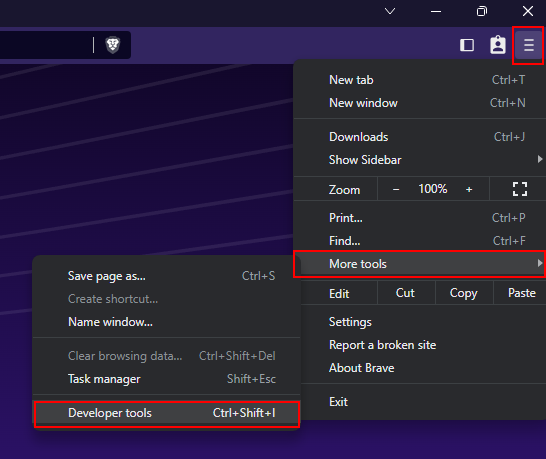

1. Click on the three vertical dots on Chrome’s top menu bar
2. Choose “More tools”
3. Select Developer tools.

**Option 2: Menu Select**

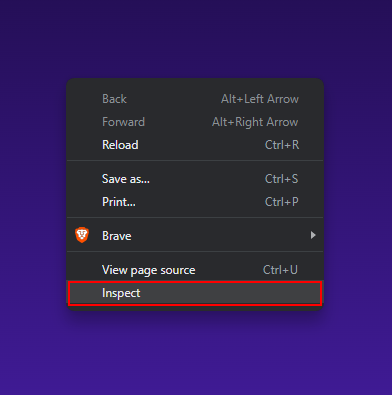

1. Right-click on the web page
2. Choose “Inspect” to access the Developer tools panel


## Inspecting the Page

Seeing that all of these pages are locally stored, we can choose to view them by either going into the file system to open them in our desired browser, or, we can continue to build our code by implementing the following snippet of code.


In [ ]:
with open("notebooks/Rookies/2000.html") as f:
    page = f.read()

Below is the loaded page with Developer Tools docked to the right. Notice how hovering the mouse cursor on the HTML line containing the class ID `rookies` highlights the table element on the page?

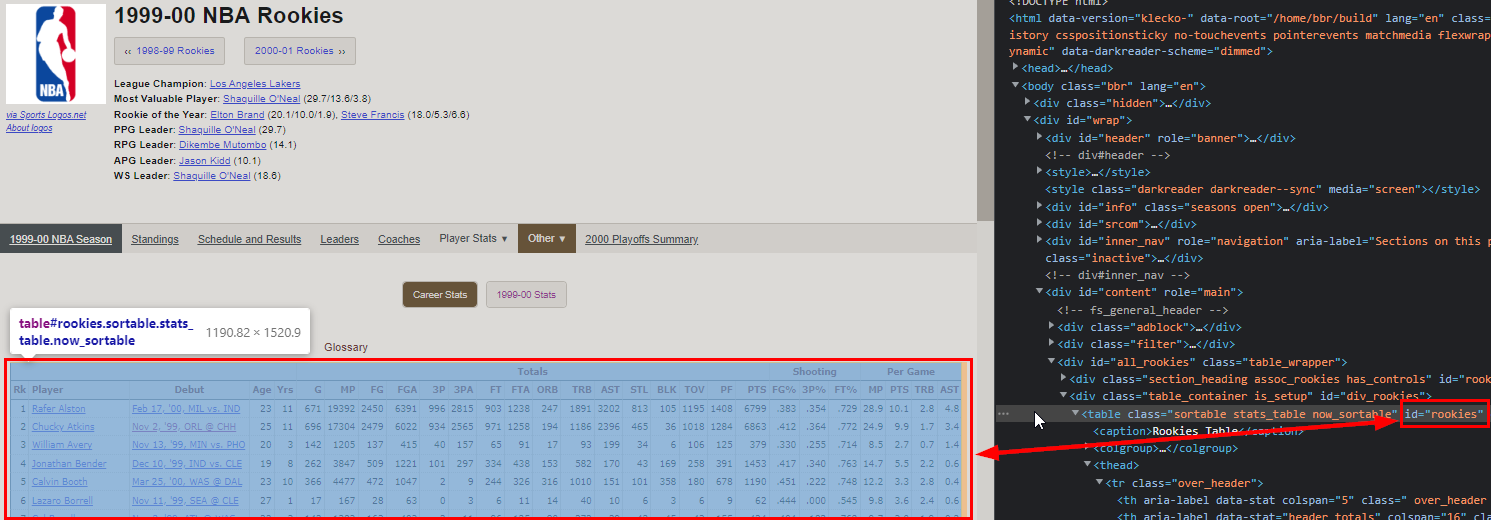

All of the desired data on this page is housed in that table element. Before hastily sucking up all of this data as is, now is the best time to consider whether *everything* on this table is worth collecting.


## Pre-Clean

Pre-cleaning might not be a frequent word in your vocabulary, but for those of you seeing yourself scraping data on a regular basis, it should be. If you want to avoid the frustration of wasted hours of progress on a data collection project, it’s best to first separate the chaff from the wheat.

For instance, take note of the three elements boxed in red.

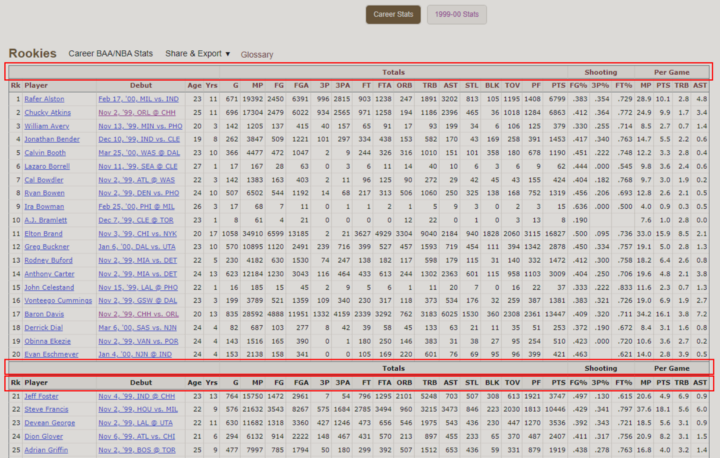

One row serves as the “main” table header. The other two rows are duplicate instances of the same artifacts found at the top. This pattern repeats every 20th row.

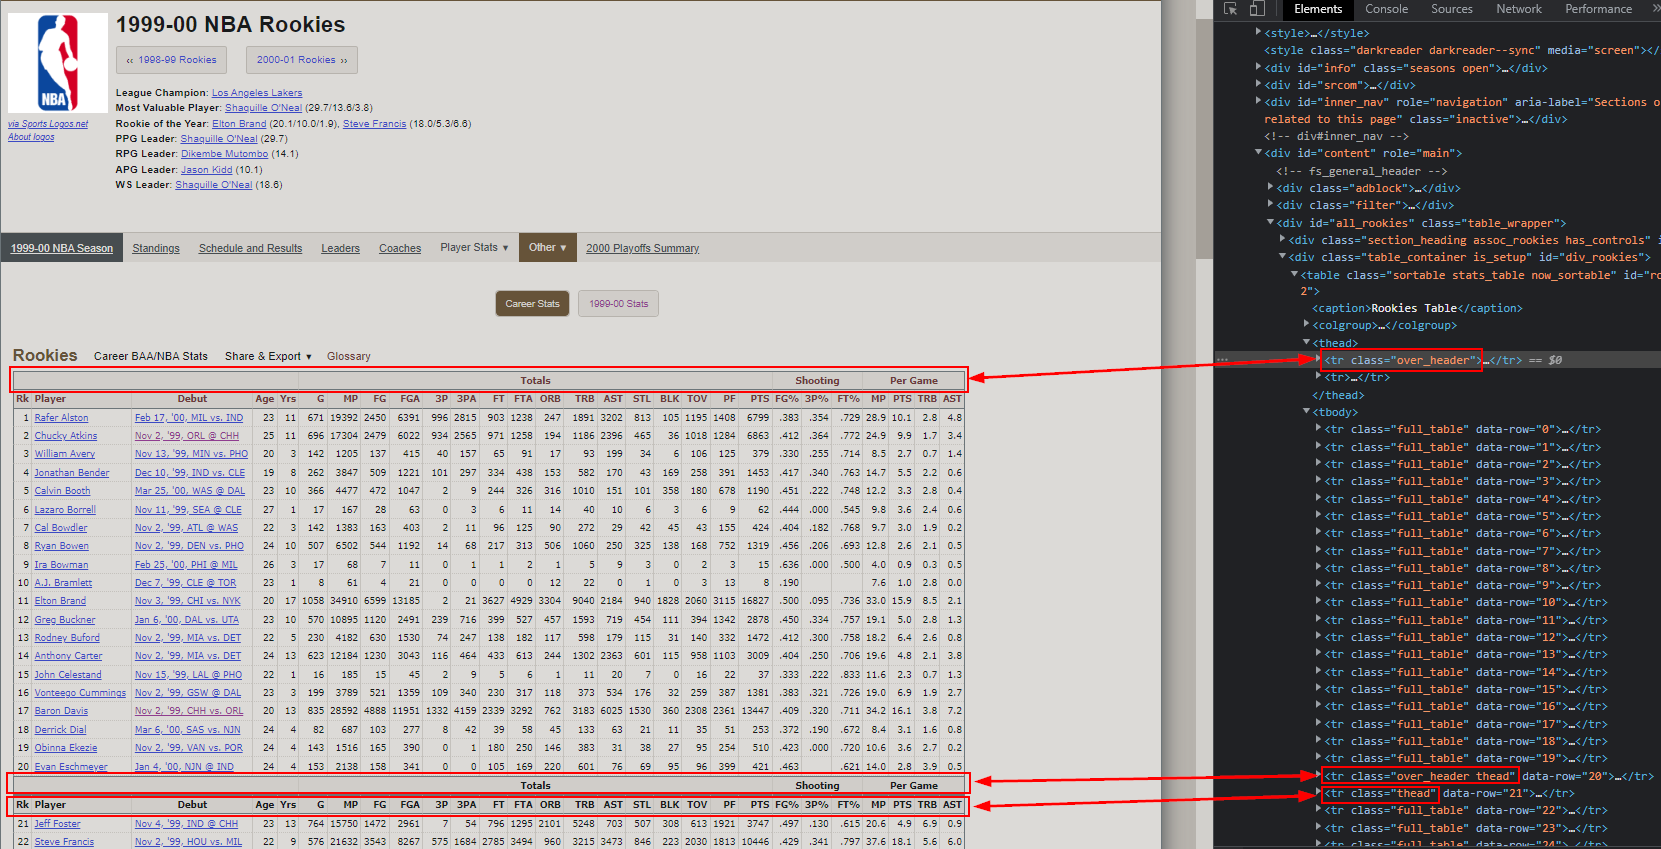

Further inspection reveals that all of these rows have the same `tr` (table row) HTML tag. What distinguishes each of these elements from any others are their class names.

1. Main Header Row
   - Class = `over_header`
2. Repeat Header Rows
   - Class = `over_header thead`
3. Statistics Category Row
   - Class = `thead`

In [1]:
#array to house list of dataframes
dfs = []
#unnecessary table rows to be removed
classes = ["over_header", "over_header thead", "thead"]

1. `dfs` will be used later on to house several dataframes
2. The `classes` array object will hold all of the unnwated table row element's class names.

Knowing that these elements provide no statisical value, rather than simply "skipping over" them in our parse, they should be instead be completely **omitted**. That's to say, permanently removed from any future considerations. 

The `decompose` method serves to remove such unwanted elements in a page. As per the official [Beautiful Soup documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#decompose)...
>`decompose()`
>
> `Tag.decompose()` removes a tag from the tree, then completely destroys it and its contents. 

Below is a snippet of code where we were able to optimize the `decompose` method with help of `for` loops.

In [ ]:
#for loop to iterate through the years 
for year in years:
    with open("notebooks/Rookies/{}.html".format(year)) as f:
        page = f.read()
    soup = BeautifulSoup(page, "html.parser")
    #for loop cleans up unnecessary table headers from reappearing in rows
    for i in classes:
        for tr in soup.find_all("tr", {"class":i}):
            tr.decompose()

1. First `for` loop is used to iterate through the values of our `years` list object  
2. The `with` method provides our code the structure for the `page` variable to read locally stored HTML files when called on
3. An HTML parser class is initialized by instantiating the Beautiful Soup class and passing in both the`page` string object, and `html.parser`
4. Second `for` loop iterates through the values in the `classes` array
4. Third `for` loop utilizes Beautiful Soup’s `find_all` method to identify elements that have **both** `tr` tags and class names matching those in `classes` 
5. `tr.decompose` serves to omit each of the identified table row elements from the page entirely

Let's look to build on this by extracting the data we *do* want.


## Extracting the Data

We can finally start working on the part of the code that actually extracts data from the table. Remember that the table in with all of the relevant data has the HTML unique ID `rookies`. The following additions to our code will serve to parse the data of this table.

In [ ]:
#the years we wish to parse for
years = list(range(1990, 2017))
#array to house list of dataframes
dfs = []
#unnecessary table headers to be removed
classes = ["over_header","over_header thead", "thead"]
 
for year in years:
    #url = url_base.format(year)
    #data = requests.get(url)
    ##page is saved as an html and placed in Rookies folder
    #with open("notebooks/Rookies/{}.html".format(year), "w+") as f:
        #f.write(data.text)
     #with open("notebooks/Rookies/2000.html") as f:
    with open("notebooks/Rookies/{}.html".format(year)) as f:
        page = f.read()
      soup = BeautifulSoup(page, "html.parser")   #for loop cleans up unnecessary table headers from reappearing in rows
    for i in classes:
        for tr in soup.find_all("tr", {"class":i}):
        tr.decompose()
        
### Scraping Block ###
    #identifies, scrapes, and loads rookie tables into one dataframe
    rookie_table = soup.find(id="rookies")
    rookies = pd.read_html(str(rookie_table))[0]
    rookies["Year"] = year
    dfs.append(rookies)

#new variable turns list of dataframes into single dataframe
all_rookies = pd.concat(dfs)

For what follows `###Scraping Block ###`
1. `rookie_table` instatiates Beautiful Soup's class `find` method to identify the HTML element with ID `rookies`
2. Seeing that Pandas can read HTML tables, the rookie table is loaded into Pandas using the `read_html` method, passing into it `rookie_table` as a string
3. Tacking on to end `[0]` turns `rookies` from a list of data frames into a single data frame
5. A “Year” column is created to correspond freshmen year added to the rookies data frame 
6. `dfs.append(rookies)` serves to house all of tables of every rookie year in the order they were they iterated into a list of data frames
6. The Pandas method `concat` is used to combine the list of data frames into one single dataframe: `all_rookies`


## Archiving

Our final step involves taking all of this useful, clean information and archiving it in easily human and machine readable CSV format. Tacking on this line to the end of our code will serve to be useful when deciding to come back and reference the data collected.

In [ ]:
#a single dataframe archived as a local CSV using Pandas
all_rookies.to_csv("archive/NBA_Rookies_1990-2016.csv")


## Final Product


In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

years = list(range(1990, 2017))
dfs = []
classes = ["over_header","over_header thead", "thead"] #unnecessary table headers to be removed

for year in years:
    with open("/Rookies/{}.html".format(year), encoding = "utf-8") as f:
        page = f.read()
    soup = BeautifulSoup(page, "html.parser")
    #second for loop cleans up unnecessary table headers from reappearing in rows
    for i in classes:
        for tr in soup.find_all("tr", {"class":i}):
            tr.decompose()
    #identifies, scrapes, and loads rookie tables into one dataframe
    table_rookies = soup.find(id="rookies")
    rookies = pd.read_html(str(table_rookies))[0]
    rookies["Year"] = year
    dfs.append(rookies)

#new variable turns list of dataframes into single dataframe
all_rookies = pd.concat(dfs)

#dataframe archived as local CSV
all_rookies.to_csv("archive/NBA_Rookies_1990-2016.csv")


## Closing

Again, the process followed in this walkthrough will undoubtedly apply to most every other page on [Basketball-Reference.com](https://www.basketball-reference.com/). There are five simple steps worth taking in each instance.

1. Identify the Page URL
2. Download the Page
3. Identify the Elements
4. Pre-Clean and Extract
5. Archive

Following these five steps will help guarantee a quick and successful scraping experience.

Next up in this series will be actually using this data to gain insight on future player potential. So be on the lookout for future installments!
